In [2]:
!ls

Users  timeseries.ipynb


In [3]:
# azureml-core of version 1.0.72 or higher is required
# azureml-dataprep[pandas] of version 1.1.34 or higher is required
from azureml.core import Workspace, Dataset

subscription_id = '73e2b9e2-1b33-4342-888f-25aca2d5563f'
resource_group = 'domado'
workspace_name = 'shaktiman'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='superstoredataset')
df = dataset.to_pandas_dataframe()
df.head()

,Row ID,Order ID,Order Date,Sales,Profit,Column24
2016-11-08,1,CA-2016-152156,2016-11-08,261.9600,41.9136,None
2016-11-08,2,CA-2016-152156,2016-11-08,731.9400,219.5820,None
2016-06-12,3,CA-2016-138688,2016-06-12,14.6200,6.8714,None
2015-10-11,4,US-2015-108966,2015-10-11,957.5775,-383.0310,None
2015-10-11,5,US-2015-108966,2015-10-11,22.3680,2.5164,None


In [4]:
import warnings
warnings.filterwarnings("ignore")
import itertools # Truth tables, series -> iterations 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# Jupyter-> specific
%matplotlib inline

#Timeseries models
import statsmodels.api as sm

In [5]:
len(df)

9994

In [8]:
data = df.groupby('Order Date')
data_grouped_sales = data['Sales'].sum().reset_index()
data_grouped_profit = data['Profit'].sum().reset_index()
data_grouped_sales.tail()

,Order Date,Sales
1232,2017-12-26,769.8440
1233,2017-12-27,177.6360
1234,2017-12-28,1657.3508
1235,2017-12-29,2915.5340
1236,2017-12-30,713.7900


In [11]:
data_grouped_profit.head(8)
# there are DATES for which data is missing 

,Order Date,Profit
0,2014-01-03,0.2000
1,2014-01-04,-65.9901
2,2014-01-05,4.8840
3,2014-01-06,1358.0524
4,2014-01-07,-53.7096
5,2014-01-09,10.9180
6,2014-01-10,22.6537
7,2014-01-11,3.0814


In [12]:
data = data_grouped_sales.set_index('Order Date') # main dataset remains unchanged
# data_grouped_sales.set_index('Order Date', inplace=True) # index changed on main dataset itself

In [13]:
data.head()

,Sales
Order Date,
2014-01-03,0.000
2014-01-04,288.060
2014-01-05,19.536
2014-01-06,4407.100
2014-01-07,83.728


In [14]:
y = data['Sales'].resample('MS').mean()
y.head()
#every month has some datapoint

Order Date
2014-01-01     643.541773
2014-02-01     205.990800
2014-03-01    2308.618625
2014-04-01    1172.193708
2014-05-01     844.095250
Freq: MS, Name: Sales, dtype: float64

In [15]:
y.index.min()

Timestamp('2014-01-01 00:00:00')

In [16]:
y.index.max()

Timestamp('2017-12-01 00:00:00')

In [17]:
len(y)
# Confidence-> No longer MISSING DATA POINTS!!!

48

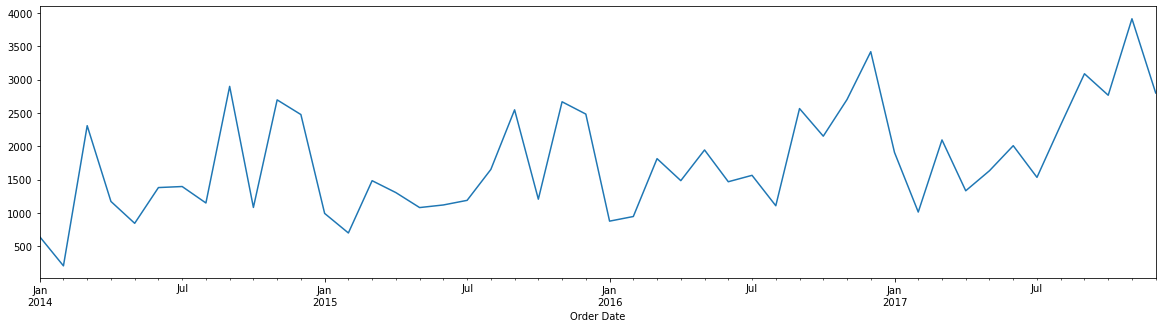

In [18]:
plt.figure()
y.plot(figsize=(20,5))
plt.show()

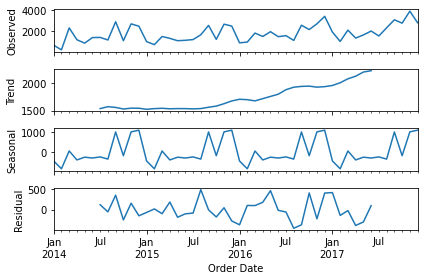

In [23]:
# COMPLEX GRAPH
# Decompose The GRAPH
# 3 entities
# ORIGINAL_GRAPH = PATTERN_PERIOD_GRAPH + TREND_SLOPE + RESIDUE_or_NOISE 
# ORIGINAL_GRAPH = repeating pattern + direction_of_progression + whatever_is_left! 

decomp_graph = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomp_graph.plot()
plt.show()

In [24]:
# vector
# v1 = v2 + v3
# i + j   =   (2i + 2j) +  (-j-i)

# HYPERPARAMETERS-> we set 

# (p,d,q) -> Auto Regression integrated seasons with Moving Averages 
# (p d q) X S (p,d,q)-> Seasonal ARIMAX
# Akaike Info Criterion-> AIC Score (ERROR)
# (1 0 1) X 1 (1 1 1 ) => AIC_score1
# (1 1 1) X 1 (0 0 1)  => AIC_score2

# best algorithm will be the combination of (pdq)XS(pdq) where the value of AIC is minimum 

# exhaustive TRUTH table that could have been formed
# HYPERPARAMETER OPTIMIZATION

# Grid SEARCH-> exhaustively creates EVERY possible combination of HPs
# typically used for discrete values
# returns the BEST possible HP set

# Randomized Search-> infinite answers possible-> WORKABLE set of HPs instead of the best pair
# (which could've taken infinite time!)

# Bayesian Search-> next HP set will be selected probabilistically 

In [25]:
p=d=q = range(0,2)
pdq = list(itertools.product(p,d,q))
print(pdq)
# 0-> dont use this HP
# 1 -> use this HP!
# good for ARIMAX

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [26]:
# seasons-> manually decide the time frame of repeating!
# 1 year as REPEAT of seasons 

seasons = 12 # collection of 12 x-axis values (monthly) to be considered as 1 PERIOD

seasonpdq =  [ (x[0],x[1],x[2], seasons)  for x in pdq ]

pdq_idx = 5

for season_idx in range(5):
    print('SARIMAX individual model = {} X {} '.format(pdq[pdq_idx], seasonpdq[season_idx]))


SARIMAX individual model = (1, 0, 1) X (0, 0, 0, 12) 
SARIMAX individual model = (1, 0, 1) X (0, 0, 1, 12) 
SARIMAX individual model = (1, 0, 1) X (0, 1, 0, 12) 
SARIMAX individual model = (1, 0, 1) X (0, 1, 1, 12) 
SARIMAX individual model = (1, 0, 1) X (1, 0, 0, 12) 


In [27]:
min_pdq = (999,999,999)
min_spdq = (999,999,999, 12)
min_AIC = 999


In [29]:
# BUILD all possible models-> 0 .. 1-> discrete
counter = 1
for param in pdq:
    for sparam in seasonpdq:
        try:
            #some of these time series model-> can result in Div by 0 conditions
            # graph crashes and ALGORITHM/MODEL remains complete
            # AIC score may not be calculated and an exception might occur
            model = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=sparam)
            predictions = model.fit()
            print('model '+ str(counter) + '= {} X {} , AIC = {} '.format(param, sparam, predictions.aic ))
            if(predictions.aic < min_AIC):
                min_AIC = predictions.aic
                min_pdq = param
                min_spdq = sparam
            
            
            counter = counter + 1
        except Exception as e:
            print(e)
            continue

model 1= (0, 0, 0) X (0, 0, 0, 12) , AIC = 865.2629100380259 
model 2= (0, 0, 0) X (0, 0, 1, 12) , AIC = 833.9872755473847 
model 3= (0, 0, 0) X (0, 1, 0, 12) , AIC = 556.9828893725455 
maxlag should be < nobs
model 4= (0, 0, 0) X (1, 0, 0, 12) , AIC = 775.427830945678 
model 5= (0, 0, 0) X (1, 0, 1, 12) , AIC = 776.6820439955138 
model 6= (0, 0, 0) X (1, 1, 0, 12) , AIC = 557.986488358641 
maxlag should be < nobs
model 7= (0, 0, 1) X (0, 0, 0, 12) , AIC = 833.820348623311 
model 8= (0, 0, 1) X (0, 0, 1, 12) , AIC = 808.4207941703752 
model 9= (0, 0, 1) X (0, 1, 0, 12) , AIC = 558.1204753173972 
maxlag should be < nobs
model 10= (0, 0, 1) X (1, 0, 0, 12) , AIC = 821.5559275770008 
model 11= (0, 0, 1) X (1, 0, 1, 12) , AIC = 771.0247947608273 
model 12= (0, 0, 1) X (1, 1, 0, 12) , AIC = 558.1927367820151 
maxlag should be < nobs
model 13= (0, 1, 0) X (0, 0, 0, 12) , AIC = 776.7991797119755 
model 14= (0, 1, 0) X (0, 0, 1, 12) , AIC = 767.5994000688486 
model 15= (0, 1, 0) X (0, 1, 0, 12

In [30]:
print(min_pdq)
print(min_spdq)
print(min_AIC)

(0, 1, 1)
(1, 1, 0, 12)
535.076313600365


In [31]:
# HP optimization has told you what the best model is
# now its our turn to build this best model and apply it
model = sm.tsa.statespace.SARIMAX(y, order=min_pdq, seasonal_order=min_spdq)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(1, 1, 0, 12)   Log Likelihood                -264.538
Date:                            Fri, 30 Apr 2021   AIC                            535.076
Time:                                    13:01:01   BIC                            539.742
Sample:                                01-01-2014   HQIC                           536.687
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8806      0.102     -8.615      0.000      -1.081      -0.680
ar.S.L12      -0.5524      0.159     -3.476      0.001      -0.864      -0.241
sigma2      1.873e+05   5.52e+04      3.392      0.001    7.91e+04    2.96e+05
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.98
Prob(Q):                               nan   Prob(JB):                         0.61
Heteroskedasticity (H):               2.30   Skew:                             0.26
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""